### Importing basic libraries

In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)

### Mounting drive and downloading files from Kaggle

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#!pip install kaggle

In [ ]:
#!pip install --upgrade --force-reinstall --no-deps kaggle

No need to run this cells now, download has been done. But code will remain for future reference

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucasmaretti","key":"f4e550a4f9939a802dc346669507c1ca"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
os.environ['KAGGLE_USERNAME'] = "lucasmaretti" # username from the json file
os.environ['KAGGLE_KEY'] = "f4e550a4f9939a802dc346669507c1ca" # key from the json file

Mounted at /content/drive/


***Run this cell to change to correct folder containing the data***

In [ ]:
os.chdir("./drive/My Drive/fraudd")

No need to run these guys below

In [ ]:
#!kaggle competitions download -c ieee-fraud-detection

In [ ]:
!ls

ieee-fraud-detection.zip  test_identity.csv	train_transaction.csv
kaggle.json		  test_transaction.csv
sample_submission.csv	  train_identity.csv


In [ ]:
import zipfile
with zipfile.ZipFile("ieee-fraud-detection.zip","r") as zip_ref:
    zip_ref.extractall()

### Exploratory data analysis

Train dataset

In [ ]:
train_transaction = pd.read_csv('train_transaction.csv')
train_id = pd.read_csv('train_identity.csv')
df_train = train_transaction.merge(train_id, how='outer', on='TransactionID')

In [ ]:
del train_transaction
del train_id

Test dataset

In [ ]:
test_transaction = pd.read_csv('test_transaction.csv')
test_id = pd.read_csv('test_identity.csv')
df_test = test_transaction.merge(test_id, how='outer', on='TransactionID')

In [ ]:
del test_transaction
del test_id

In [ ]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


Variables description according to Vesta:

**1) Identity table**

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

***Categorical Features***:

DeviceType

DeviceInfo

id_12 - id_38

**2) Transaction table**





TransactionDT: timedelta from a given reference datetime (not an actual timestamp)

TransactionAMT: transaction payment amount in USD

ProductCD: product code, the product for each transaction

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

addr: address

dist: distance

P_ and (R__) emaildomain: purchaser and recipient email domain

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

D1-D15: timedelta, such as days between previous transaction, etc.

M1-M9: match, such as names on card and address, etc.

Vxxx: Vesta engineered rich features, including ranking, counting, and other 
entity relations.

***Categorical Features***:
ProductCD

card1 - card6

addr1, addr2

P_emaildomain

R_emaildomain

M1 - M9

In [ ]:
pd.options.display.max_rows = 50
df_train.isna().mean().sort_values(ascending = False)

id_24            0.991962
id_25            0.991310
id_07            0.991271
id_08            0.991271
id_21            0.991264
                   ...   
C11              0.000000
C12              0.000000
C13              0.000000
C14              0.000000
TransactionID    0.000000
Length: 434, dtype: float64

In [ ]:
vars = df_train.isna().mean().to_frame().reset_index()

In [ ]:
vars.head()

,index,0
0,TransactionID,0.0
1,isFraud,0.0
2,TransactionDT,0.0
3,TransactionAmt,0.0
4,ProductCD,0.0


In [ ]:
vars.columns = ["vars", "percent"]

In [ ]:
cut = 0.25
#len(vars[vars["percent"] > cut].index)

print("{} variables have over {}% of NA values, a total of {}% of total variables".format(len(vars[vars["percent"] > cut].index), cut*100, (len(vars[vars["percent"] > cut].index)/434)*100))

252 variables have over 25.0% of NA values, a total of 58.06451612903226% of total variables


In [ ]:
cut = 0.5
#len(vars[vars["percent"] > cut].index)

print("{} variables have over {}% of NA values, a total of {}% of total variables".format(len(vars[vars["percent"] > cut].index), cut*100, (len(vars[vars["percent"] > cut].index)/434)*100))

214 variables have over 50.0% of NA values, a total of 49.30875576036866% of total variables


In [ ]:
cut = 0.75
#len(vars[vars["percent"] > cut].index)

print("{} variables have over {}% of NA values, a total of {}% of total variables".format(len(vars[vars["percent"] > cut].index), cut*100, (len(vars[vars["percent"] > cut].index)/434)*100))

208 variables have over 75.0% of NA values, a total of 47.926267281105986% of total variables


In [ ]:
del vars

In [ ]:
var_list = df_train.columns.to_list()

In [ ]:
var_list

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

Types of variables - these groups will be used to stratify the EDA

C* variables = 14

D* variables = 15

M* variables = 9

V* variables = 339

id_* variables = 38

Other categorical = 19

**Total = 434 variables**



---




Target variable: "isFraud". Checking to see if it is imbalanced. 

**We need to define a strategy for this**: over / undersampling / SMOTE, etc.

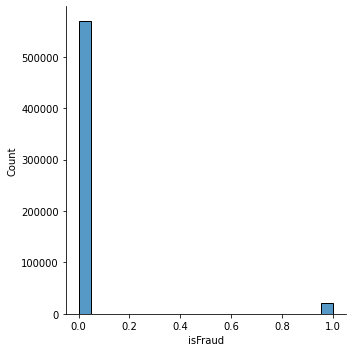

In [ ]:
sns.displot(data=df_train, x="isFraud")

## Categorical data

In [ ]:
cat_vars = ['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'DeviceType',
 'DeviceInfo']

In [ ]:
df_cat = df_train[cat_vars]

In [ ]:
df_cat.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
df_cat.isna().mean().sort_values(ascending = False)

dist2             0.936284
DeviceInfo        0.799055
R_emaildomain     0.767516
DeviceType        0.761557
dist1             0.596524
P_emaildomain     0.159949
addr2             0.111264
addr1             0.111264
card2             0.015127
card5             0.007212
card4             0.002670
card6             0.002660
card3             0.002650
card1             0.000000
ProductCD         0.000000
TransactionAmt    0.000000
TransactionDT     0.000000
isFraud           0.000000
TransactionID     0.000000
dtype: float64

To drop:


*   dist2 - over 93% of NaNs
*   DeviceInfo and Type - ~ 80% of NaNs - doesnt seem to be relevant
*   R_emaildomain and P_emaildomin - doesnt seem to be relevant
*   dist1 - 60% of NaNs







In [ ]:
to_drop = ['dist2', 'DeviceInfo', 'R_emaildomain', 'P_emaildomain', 'dist1', 'DeviceType']

In [ ]:
#numerical_features = [e for e in numerical_features if e not in targets] 

In [ ]:
df_cat = df_cat.drop(columns=to_drop)

In [ ]:
df_cat.isna().mean().sort_values(ascending = False)

addr2             0.111264
addr1             0.111264
card2             0.015127
card5             0.007212
card4             0.002670
card6             0.002660
card3             0.002650
card1             0.000000
ProductCD         0.000000
TransactionAmt    0.000000
TransactionDT     0.000000
isFraud           0.000000
TransactionID     0.000000
dtype: float64

In [ ]:
def plot_eda(var):
  plt.figure(figsize=[20,16])

  plt.subplot(311)
  sns.scatterplot(data=df_cat, x="TransactionDT", y=var, hue = "isFraud")
  plt.title('Scatterplot')

  plt.subplot(312)
  sns.histplot(data=df_cat, x=var)
  plt.title('Histogram')

  plt.subplot(313)
  sns.boxplot(x=df_cat[var])
  plt.title('Boxplot')


### Addr1 e Addr2

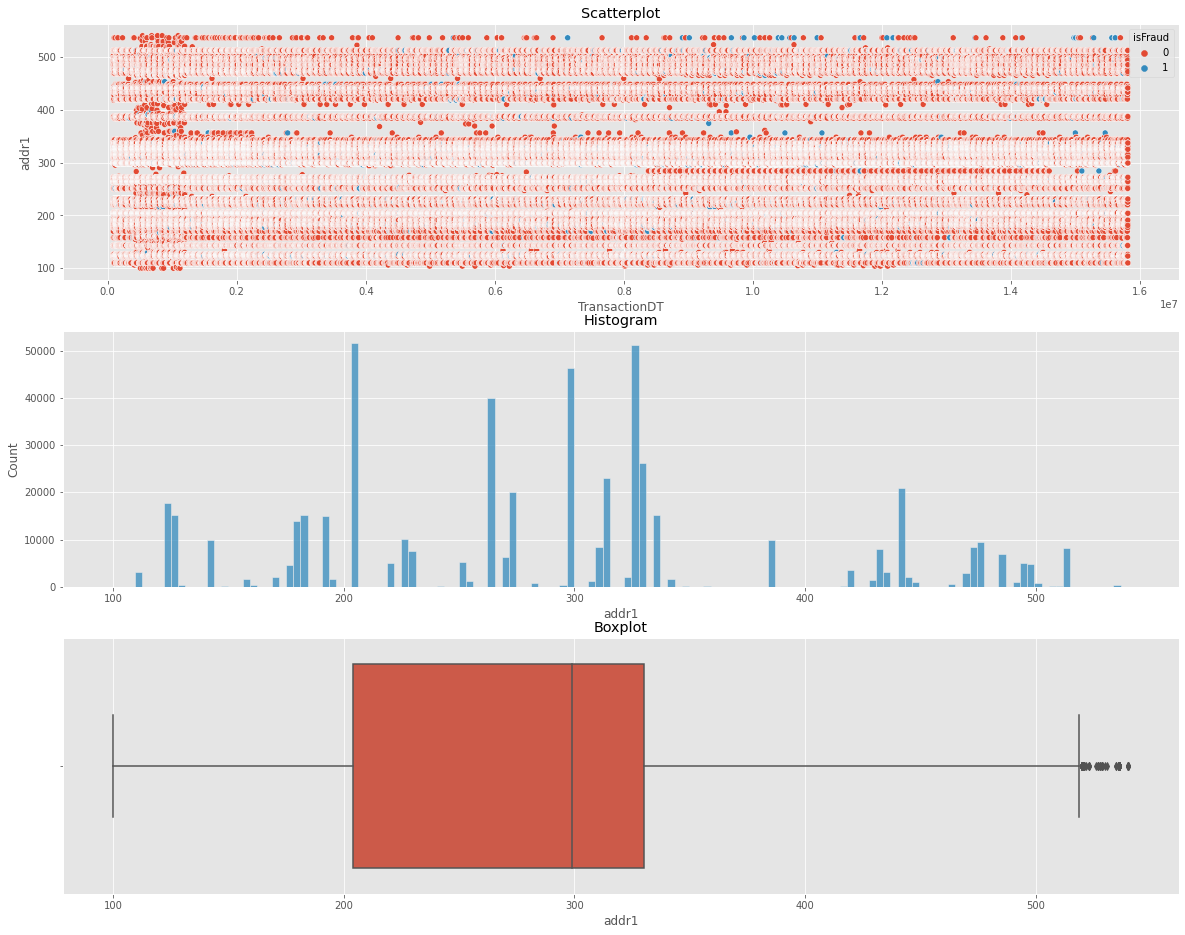

In [ ]:
plot_eda("addr1")

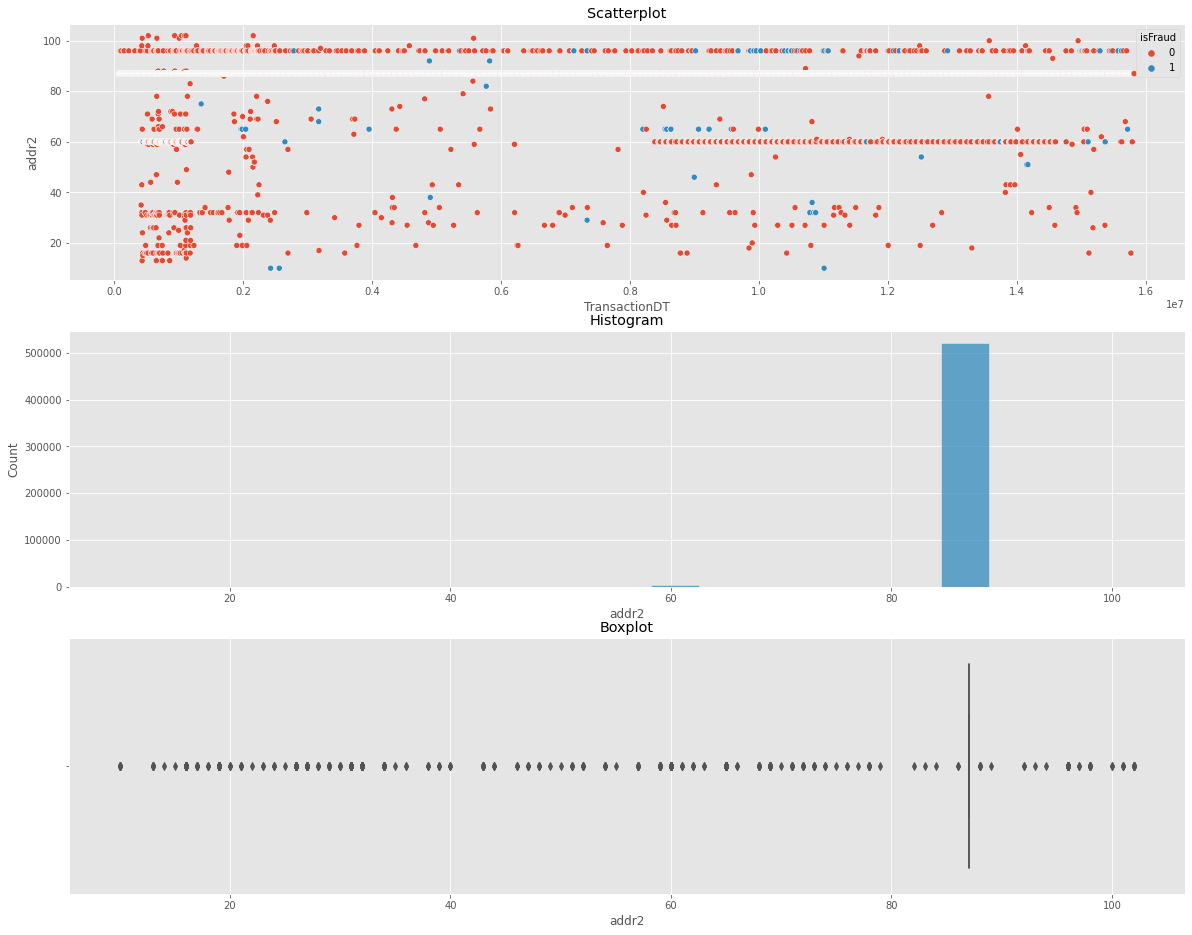

In [ ]:
plot_eda("addr2")

### Cards

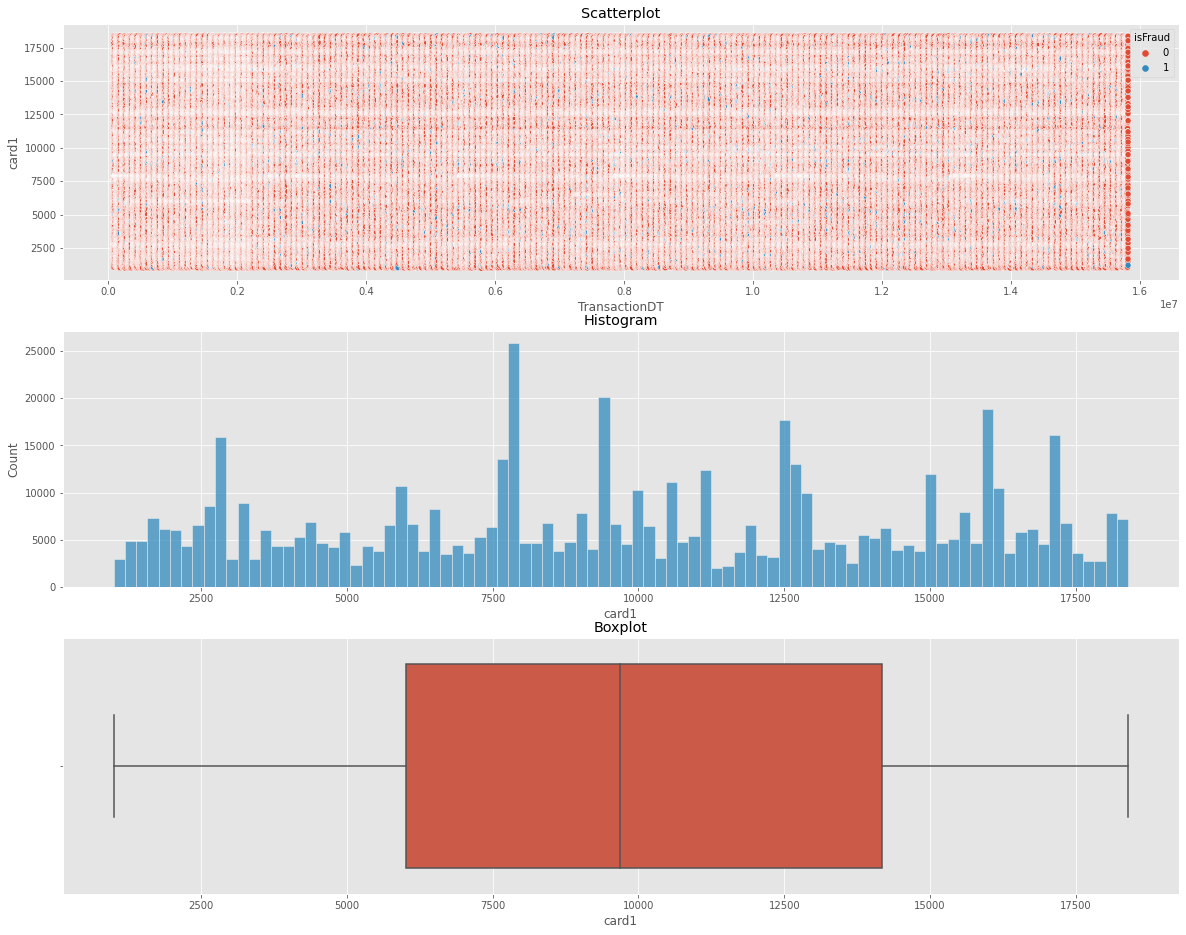

In [ ]:
plot_eda("card1")

## Numerical data

### "V" variables

In [ ]:
v_vars = [ 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V220',
 'V221',
 'V222',
 'V223',
 'V224',
 'V225',
 'V226',
 'V227',
 'V228',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 'V240',
 'V241',
 'V242',
 'V243',
 'V244',
 'V245',
 'V246',
 'V247',
 'V248',
 'V249',
 'V250',
 'V251',
 'V252',
 'V253',
 'V254',
 'V255',
 'V256',
 'V257',
 'V258',
 'V259',
 'V260',
 'V261',
 'V262',
 'V263',
 'V264',
 'V265',
 'V266',
 'V267',
 'V268',
 'V269',
 'V270',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V276',
 'V277',
 'V278',
 'V279',
 'V280',
 'V281',
 'V282',
 'V283',
 'V284',
 'V285',
 'V286',
 'V287',
 'V288',
 'V289',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V305',
 'V306',
 'V307',
 'V308',
 'V309',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V316',
 'V317',
 'V318',
 'V319',
 'V320',
 'V321',
 'V322',
 'V323',
 'V324',
 'V325',
 'V326',
 'V327',
 'V328',
 'V329',
 'V330',
 'V331',
 'V332',
 'V333',
 'V334',
 'V335',
 'V336',
 'V337',
 'V338',
 'V339',
 'TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD']

In [ ]:
df_v = df_train[v_vars]
df_v.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987000,0,86400,68.5,W
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987001,0,86401,29.0,W
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987002,0,86469,59.0,W
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987003,0,86499,50.0,W
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2987004,0,86506,50.0,H


In [ ]:
def plot_eda_v(var):
  plt.figure(figsize=[20,16])

  plt.subplot(311)
  sns.scatterplot(data=df_v, x="TransactionDT", y=var, hue = "isFraud")
  plt.title('Scatterplot')

  plt.subplot(312)
  sns.histplot(data=df_v, x=var)
  plt.title('Histogram')

  plt.subplot(313)
  sns.boxplot(x=df_v[var])
  plt.title('Boxplot')

  print(df_v[var].describe())


count    311253.000000
mean          0.999945
std           0.007390
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: V1, dtype: float64
1.0


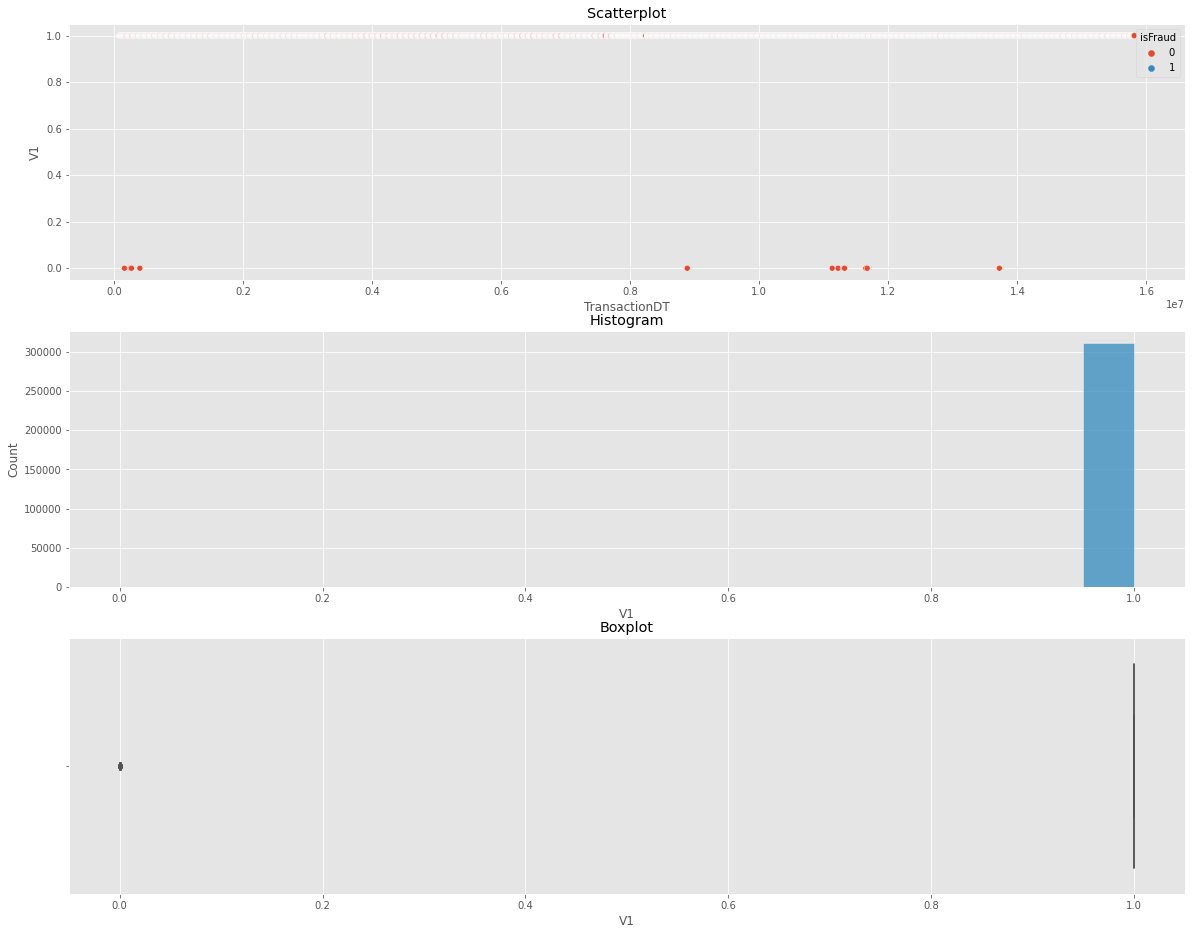

In [ ]:
plot_eda_v("V1")

In [ ]:
df_v["V1"].quantile(.75)

1.0

count    81951.000000
mean       277.598028
std        829.576922
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       3389.000000
Name: V150, dtype: float64


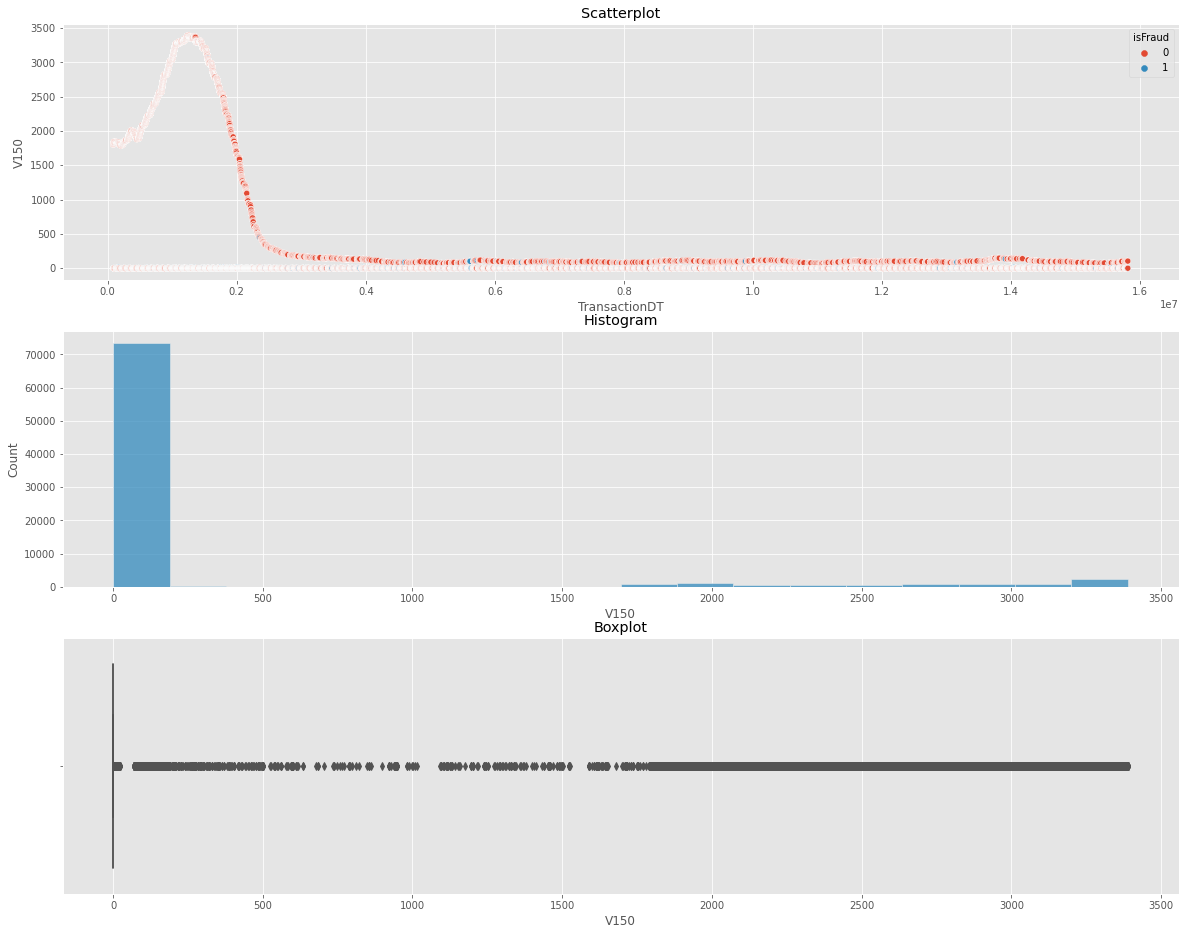

In [ ]:
plot_eda_v("V150")

count    590528.000000
mean        247.606741
std        3980.042828
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      134021.000000
Name: V317, dtype: float64


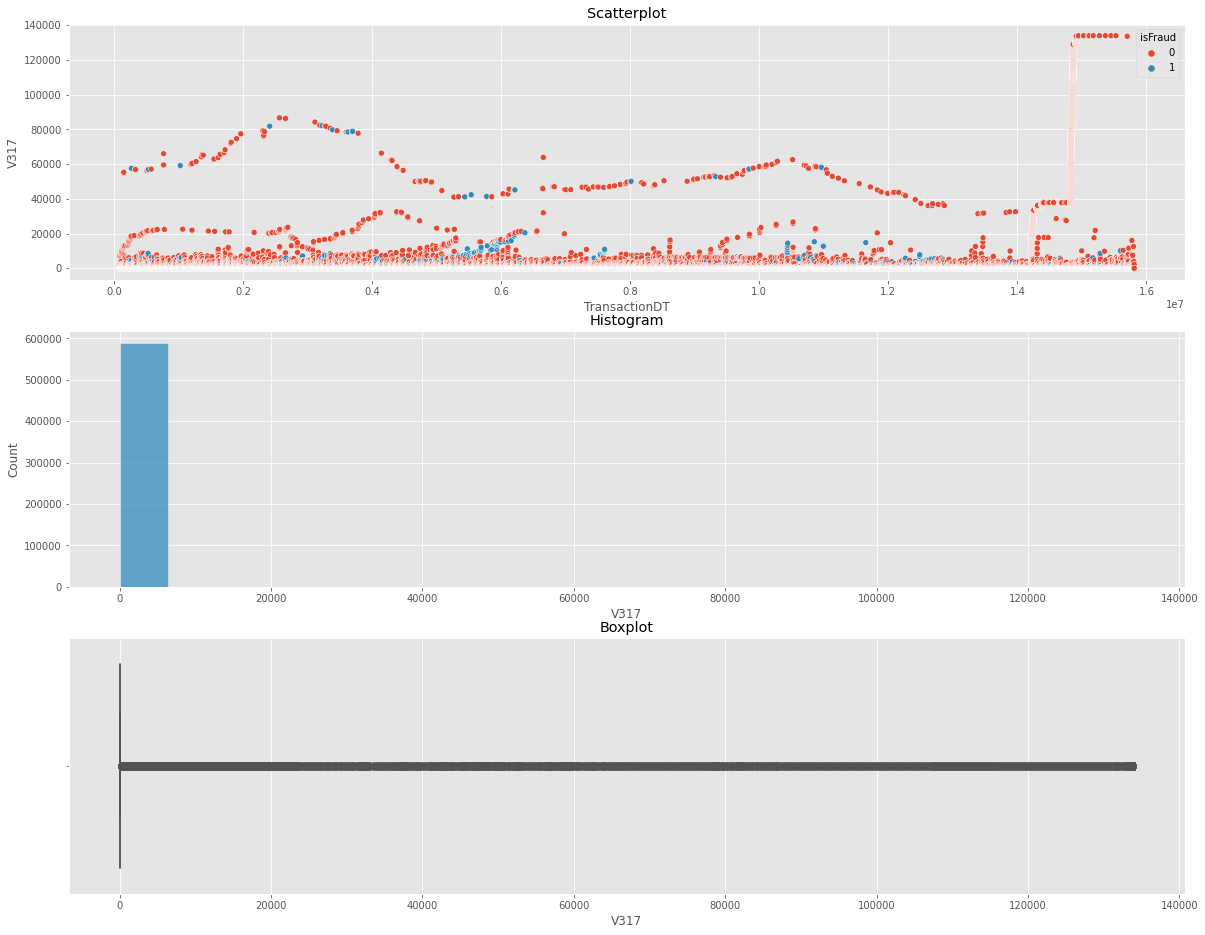

In [ ]:
plot_eda_v("V317")

# PCA Study

### Filling NAs with 75% percentile - not sure if it is the best approach

In [ ]:
df_v2 = df_v.fillna(df_v.quantile(0.75).iloc[0])

In [ ]:
df_v2.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2987000,0,86400,68.5,W
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2987001,0,86401,29.0,W
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2987002,0,86469,59.0,W
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2987003,0,86499,50.0,W
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2987004,0,86506,50.0,H


In [ ]:
v_features = [ 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V220',
 'V221',
 'V222',
 'V223',
 'V224',
 'V225',
 'V226',
 'V227',
 'V228',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 'V240',
 'V241',
 'V242',
 'V243',
 'V244',
 'V245',
 'V246',
 'V247',
 'V248',
 'V249',
 'V250',
 'V251',
 'V252',
 'V253',
 'V254',
 'V255',
 'V256',
 'V257',
 'V258',
 'V259',
 'V260',
 'V261',
 'V262',
 'V263',
 'V264',
 'V265',
 'V266',
 'V267',
 'V268',
 'V269',
 'V270',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V276',
 'V277',
 'V278',
 'V279',
 'V280',
 'V281',
 'V282',
 'V283',
 'V284',
 'V285',
 'V286',
 'V287',
 'V288',
 'V289',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V305',
 'V306',
 'V307',
 'V308',
 'V309',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V316',
 'V317',
 'V318',
 'V319',
 'V320',
 'V321',
 'V322',
 'V323',
 'V324',
 'V325',
 'V326',
 'V327',
 'V328',
 'V329',
 'V330',
 'V331',
 'V332',
 'V333',
 'V334',
 'V335',
 'V336',
 'V337',
 'V338',
 'V339']

In [ ]:
df_v_X = df_v2[v_features]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_v_X)
df_v_X_norm = scaler.transform(df_v_X)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(.95)

In [ ]:
pca.fit(df_v_X_norm)
print("Number of principal components: ", pca.n_components_)

Number of principal components:  83


In [ ]:
pca_df_v_X_norm = pca.transform(df_v_X_norm)